In [2]:
from nga.utils import load_config, plane_eval_ray_bundle, save_as_image, convert_to_transformed_space
from nerfstudio.utils.eval_utils import eval_load_checkpoint
from nerfstudio.cameras.rays import RayBundle
from nerfstudio.utils import colormaps
from nerfstudio.utils.io import load_from_json

from PIL import Image
from pathlib import Path
import yaml
import torch
import json
import numpy as np
import OpenEXR, Imath
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'OpenEXR'

In [ ]:


def load_metadata(config):
    if config.data.suffix == ".json":
        meta = load_from_json(config.data)
        data_dir = config.data.parent
    else:
        meta = load_from_json(config.data / "transforms.json")
        data_dir = config.data
    return meta, data_dir

In [ ]:
config_path = "outputs/pattern_plane1_720x480/tensorf/2023-09-08_100912/config.yml"
# config_path = "outputs/pattern_plane1_720x480/instant-ngp-bounded/2023-09-18_193840/config.yml"
# config_path = "outputs/pattern_plane1_720x480/nerfacto/2023-09-14_142127/config.yml"
# config_path = "outputs/pattern_plane1_720x480/tensorf/2023-09-17_171505/config.yml"
# config_path = "outputs/pattern_plane1_720x480/kplanes/2023-09-18_222327/config.yml"

plane_dimensions=(5.0,10.0)

config = load_config(config_path)
config.load_dir = config.get_checkpoint_dir()

meta, data_dir = load_metadata(config)


In [ ]:

# setup pipeline (which includes the DataManager)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline = config.pipeline.setup(device=device, test_mode="val")
pipeline.eval()


checkpoint_path, step = eval_load_checkpoint(config, pipeline)
results_path = config.get_base_dir() / "results.json"
render_output_path = config.get_base_dir() / "renders"
render_output_path.mkdir(parents=True, exist_ok=True)

[14:39:29] Auto image downscale factor of 1                                                 ]8;id=435656;file:///home/ccl/.conda/envs/nerfstudio/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=937947;file:///home/ccl/.conda/envs/nerfstudio/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#349\349]8;;\

            Dataset is overriding train_indices to [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ]8;id=236176;file:///home/ccl/.conda/envs/nerfstudio/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=921753;file:///home/ccl/.conda/envs/nerfstudio/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#200\200]8;;\
           30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,                              
           50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,                              
           70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,                              
           90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107,                              
           108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,                              
           124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,                              
           140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,                              
           156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,                              
           172, 173, 174, 175, 176, 177, 178, 179]                                                                      

            Dataset is overriding val_indices to [180, 181, 182, 183, 184, 185, 186, 187,   ]8;id=826842;file:///home/ccl/.conda/envs/nerfstudio/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=977925;file:///home/ccl/.conda/envs/nerfstudio/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#200\200]8;;\
           188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]                                                  

Setting up training dataset...

Caching all 160 images.

Output()

Setting up evaluation dataset...

Caching all 20 images.

Output()

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/pattern_plane1_720x480/instant-ngp/2023-09-19_084949/nerfstudio_models/step-000029999.ckpt

In [ ]:


depth_filenames = pipeline.datamanager.eval_dataset.metadata["depth_filenames"]

def read_depth_map(file_path):
    exr_file = OpenEXR.InputFile(file_path)
    dw = exr_file.header()['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    depth_str = exr_file.channel('R', pt)
    depth = np.frombuffer(depth_str, dtype=np.float32)
    depth.shape = (height, width)  # reshape
    
    return torch.unsqueeze(torch.from_numpy(depth), dim=-1).to(device=device)

# from: https://github.com/kobejean/bts/blob/d4f1de8f9c8f253cc2bcd1ce0d92fce193a72bac/pytorch/bts_eval.py#L91-L112
def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    d1 = (thresh < 1.25).mean()
    d2 = (thresh < 1.25 ** 2).mean()
    d3 = (thresh < 1.25 ** 3).mean()
    
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    
    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())
    
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean(((gt - pred) ** 2) / gt)
    
    err = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100
    
    err = np.abs(np.log10(pred) - np.log10(gt))
    log10 = np.mean(err)
    
    return silog, log10, abs_rel, sq_rel, rmse, rmse_log, d1, d2, d3

num_images = len(pipeline.datamanager.fixed_indices_eval_dataloader)
depth_silog = np.zeros(num_images, np.float32)
depth_log10 = np.zeros(num_images, np.float32)
depth_rms = np.zeros(num_images, np.float32)
depth_log_rms = np.zeros(num_images, np.float32)
depth_abs_rel = np.zeros(num_images, np.float32)
depth_sq_rel = np.zeros(num_images, np.float32)
depth_d1 = np.zeros(num_images, np.float32)
depth_d2 = np.zeros(num_images, np.float32)
depth_d3 = np.zeros(num_images, np.float32)

for camera_ray_bundle, batch in pipeline.datamanager.fixed_indices_eval_dataloader:
    image_idx = batch["image_idx"]
    depth_filepath = depth_filenames[image_idx]
    depth_gt = read_depth_map(str(depth_filepath))
    mask = depth_gt <= 1000
    depth_gt[depth_gt > 1000] = torch.min(depth_gt[mask])
    outputs = pipeline.model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

    rgb_pred = outputs["rgb"]
    rgb_gt = batch["image"]
    acc = outputs["accumulation"]
    acc_vis = colormaps.apply_colormap(acc)

    depth_pred = outputs["depth"]

    depth_pred_vis = colormaps.apply_depth_colormap(
        depth_pred,
        accumulation=outputs["accumulation"],
    )
    depth_gt_vis = colormaps.apply_depth_colormap(
        depth_gt,
    )
    depth_gt_vis = torch.concat([depth_gt_vis, mask], dim=-1)
    depth_diff = depth_pred - depth_gt
    depth_diff[depth_gt > 1000] = torch.min(depth_diff[mask])
    depth_diff_vis = colormaps.apply_depth_colormap(
        depth_diff,
    )
    depth_diff_vis = torch.concat([depth_diff_vis, mask], dim=-1)

    save_as_image(rgb_pred, render_output_path / f"rgb_pred_{image_idx:04d}.png")
    save_as_image(rgb_gt, render_output_path / f"rgb_gt_{image_idx:04d}.png")
    save_as_image(acc_vis, render_output_path / f"acc_{image_idx:04d}.png")
    save_as_image(depth_pred_vis, render_output_path / f"depth_pred_{image_idx:04d}.png")
    save_as_image(depth_gt_vis, render_output_path / f"depth_gt_{image_idx:04d}.png")
    save_as_image(depth_diff_vis, render_output_path / f"depth_diff_{image_idx:04d}.png")

    depth_silog[image_idx], depth_log10[image_idx], depth_abs_rel[image_idx], depth_sq_rel[image_idx], depth_rms[image_idx], depth_log_rms[image_idx], depth_d1[image_idx], depth_d2[image_idx], depth_d3[image_idx] = compute_errors(
            depth_gt[mask].to("cpu").numpy(), depth_pred[mask].to("cpu").numpy())
    
    

/tmp/ipykernel_60826/2256199064.py:14: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.unsqueeze(torch.from_numpy(depth), dim=-1).to(device=device)


/home/ccl/.conda/envs/nerfstudio/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


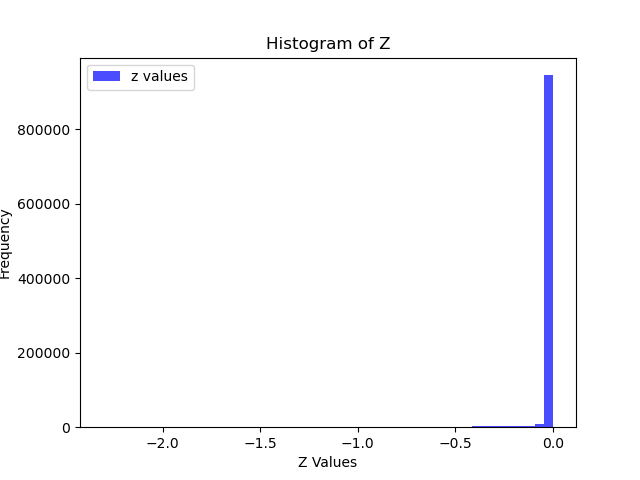

701

In [ ]:


# load data for coverting between original and normalized coodinate space
dataparser_transforms_path = config.get_base_dir() / "dataparser_transforms.json"
dataparser_transforms_data = json.load(open(dataparser_transforms_path))
dataparser_scale = dataparser_transforms_data["scale"]
transform = torch.tensor(dataparser_transforms_data["transform"])

sampling_width = 0.5
camera_ray_bundle = plane_eval_ray_bundle(dataparser_transforms_data, sampling_width, dimensions=plane_dimensions).to(device)
outputs = pipeline.model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

rgb = outputs["rgb"]
depth = outputs["depth"]
mask = depth < 2 * sampling_width
mask = torch.abs(depth - torch.mean(depth)) < 1 * torch.std(depth)
acc = colormaps.apply_colormap(outputs["accumulation"])
depth_vis = torch.clone(depth)
depth_vis[torch.logical_not(mask)] = torch.min(depth[mask])
depth_vis = colormaps.apply_depth_colormap(
    depth_vis,
    accumulation=outputs["accumulation"],
)
depth_vis = torch.concat([depth_vis, mask], dim=-1)

z = sampling_width - (outputs["depth"] / dataparser_scale)
z_vis = torch.clone(z)
z_vis[torch.logical_not(mask)] = torch.min(z[mask])
z_vis = colormaps.apply_depth_colormap(
    z_vis,
    accumulation=outputs["accumulation"],
)
z_vis = torch.concat([z_vis, mask], dim=-1)

save_as_image(rgb, render_output_path / "rgb.png")
save_as_image(acc, render_output_path / "acc.png")
save_as_image(depth_vis, render_output_path / "depth.png")
save_as_image(z_vis, render_output_path / "z.png")
torch.save(z_vis, render_output_path / "z.pt")

plt.hist(z.cpu().numpy().flatten(), bins=50, color='blue', alpha=0.7, label='z values')
plt.xlabel('Z Values')
plt.ylabel('Frequency')
plt.title('Histogram of Z')
plt.legend()
plt.savefig(render_output_path / 'z_hist.jpeg')
plt.show()

# Get the output and define the names to save to
benchmark_info = {
    "experiment_name": config.experiment_name,
    "method_name": config.method_name,
    "checkpoint": str(checkpoint_path),
    "results": {
        "max_z": float(torch.max(z)),
        "min_z": float(torch.min(z)),
        "std_z": float(torch.std(z)),
        "mean_z": float(torch.mean(z)),
        "depth_metrics": {
            "silog": float(depth_silog.mean()),
            "log10": float(depth_log10.mean()),
            "abs_rel": float(depth_abs_rel.mean()),
            "sq_rel": float(depth_sq_rel.mean()),
            "rms": float(depth_rms.mean()),
            "log_rms": float(depth_log_rms.mean()),
            "d1": float(depth_d1.mean()),
            "d2": float(depth_d2.mean()),
            "d3": float(depth_d3.mean()),
        }
    },
}
# Save output to output file
results_path.write_text(json.dumps(benchmark_info, indent=2), "utf8")

(1001, 1001)


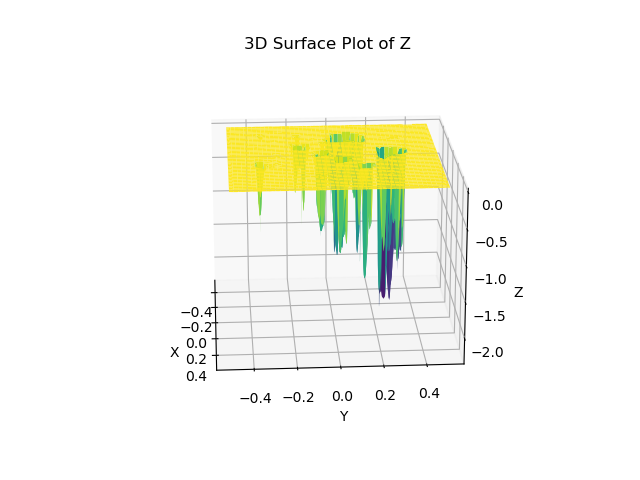

In [ ]:
%matplotlib widget
from matplotlib.animation import FuncAnimation

# Convert PyTorch tensor to NumPy array
z_numpy = z.squeeze().cpu().numpy()
print(z_numpy.shape)

# Create x and y coordinates for 1x1 xy-plane centered at origin
x = np.linspace(-0.5, 0.5, 1001)
y = np.linspace(-0.5, 0.5, 1001)
x, y = np.meshgrid(x, y)

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x, y, z_numpy, cmap='viridis')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface Plot of Z')

# Function to update the plot at each frame
def update(frame):
    ax.view_init(elev=20., azim=3.6*frame)
    return surface,

# Create animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 100), blit=False, repeat=False)

# To save the animation
ani.save(render_output_path / '3D_rotation.gif', writer='imagemagick')


# Show plot
plt.show()



In [ ]:
ani.s

In [ ]:
%matplotlib inline
# Number of slices
num_slices = 10

# Create the slices
for i in range(num_slices):
    # Choose an index for the cross-section along the x-axis
    slice_index = int((i + 0.5) * (z_numpy.shape[0] / num_slices))  # Replace this with a suitable value within [0, 1000]

    # Extract the slice
    z_slice = z_numpy[slice_index, :]

    # Plotting
    plt.figure()
    plt.plot(y, z_slice)
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title(f'Cross-Section at X-Index {slice_index}')
    plt.savefig(render_output_path / f'cross_section_{slice_index}.jpeg')
    # plt.show()
